- モデル計算

# Library

In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings
warnings.filterwarnings('ignore')

In [56]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [57]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [58]:
# model
import lightgbm as lgb

# shap
import shap

In [65]:
# my_tool
import sys
sys.path.append('../../')
import importlib
from utils import my_ds_tools as mdt
importlib.reload(mdt)

<module 'utils.my_ds_tools' from '../..\\utils\\my_ds_tools.py'>

# Config

In [6]:
VERSION = 'v1'
USAGE = 'tree'
INPUT_DIR = '../intermediate/'

In [7]:
Y_COL = 'Survived'
DROP_COLS = ['PassengerId']

# Load data

In [8]:
train_df = pd.read_csv(INPUT_DIR + 'train_for_' + USAGE + '_' + VERSION + '.csv')
test_df = pd.read_csv(INPUT_DIR + 'test_for_' + USAGE + '_' + VERSION + '.csv')

# Preprocess

In [9]:
feature_cols = [
#     'Unnamed: 0',
#     'PassengerId',
    'Pclass',
#     'Name',
    'Sex',
#     'Age',
#     'SibSp',
#     'Parch', 
#     'Ticket', 
#     'Fare',
#     'Cabin',
    'Embarked',
#     'name_title',
    'ticket_length',
    'cabin_length',
    'cabin_initial',
    'fixed_age',
#     'age_rank',
    'fixed_fare',
    'is_alone',
#     'Survived'
]
# train_df.columns

In [10]:
x = train_df.loc[:, feature_cols]
y = train_df.loc[:, Y_COL]

In [11]:
prepro_tool = mdt.DS_PREPROCESS(x, y)

In [12]:
prepro_tool.show_desc_features()

Categorical
['Sex', 'Embarked', 'cabin_initial']
Numerical
['Pclass', 'ticket_length', 'cabin_length', 'fixed_age', 'fixed_fare', 'is_alone']


In [13]:
prepro_x = prepro_tool.label_encode_x()
prepro_tool.check_null_x(prepro_x)

Pclass           0
Sex              0
Embarked         0
ticket_length    0
cabin_length     0
cabin_initial    0
fixed_age        0
fixed_fare       0
is_alone         0
dtype: int64

In [31]:
x_train, x_test, y_train, y_test = train_test_split(prepro_x, y)

# Calculate model

In [37]:
prepro_x.head()

,Pclass,Sex,Embarked,ticket_length,cabin_length,cabin_initial,fixed_age,fixed_fare,is_alone
0,3,1,2,8,3,8,22.0,1.981001,0
1,1,0,0,7,3,2,38.0,4.266662,0
2,3,0,2,14,3,8,26.0,2.070022,1
3,1,0,2,6,4,2,35.0,3.972177,0
4,3,1,2,6,3,8,35.0,2.085672,1


In [50]:
models = [
    'lgb',
#     'rbf_svm',
#     'linear_svm',
    'logit',
    'dt',
    'rf',
    'nb',
#     'knn',
    'vote'
]
model_tool = mdt.DS_MODEL()
for m in models:
    print(m)
#     model_tool.class_fit_predict(x_train, x_test, y_train, y_test, m)
    model_tool.class_fit_predict_cv(m, prepro_x, y)
    print('---------------------------------')

lgb
auc:	0.8202
accuracy:	0.8362
precision:	0.8089
recall:	0.7514
f1:	0.7779
---------------------------------
logit
auc:	0.7636
accuracy:	0.7767
precision:	0.7102
recall:	0.7075
f1:	0.7080
---------------------------------
dt
auc:	0.7731
accuracy:	0.7857
precision:	0.7235
recall:	0.7193
f1:	0.7208
---------------------------------
rf
auc:	0.7849
accuracy:	0.8003
precision:	0.7527
recall:	0.7193
f1:	0.7340
---------------------------------
nb
auc:	0.7116
accuracy:	0.7341
precision:	0.6633
recall:	0.6145
f1:	0.6365
---------------------------------
vote
auc:	0.7998
accuracy:	0.8171
precision:	0.7832
recall:	0.7253
f1:	0.7517
---------------------------------


# EDA by SHAP

In [66]:
fitted_models = model_tool.get_estimators()
fitted_models

{'lgb': LGBMClassifier(min_split_gain=0, num_leaves=100),
 'logit': LogisticRegression(random_state=1),
 'dt': DecisionTreeClassifier(random_state=1),
 'rf': RandomForestClassifier(random_state=1),
 'nb': GaussianNB(),
 'vote': VotingClassifier(estimators=dict_items([('lgb', LGBMClassifier(min_split_gain=0, num_leaves=100)), ('logit', LogisticRegression(random_state=1)), ('dt', DecisionTreeClassifier(random_state=1)), ('rf', RandomForestClassifier(random_state=1)), ('nb', GaussianNB()), ('vote', VotingClassifier(estimators=...))]))}

In [67]:
shap_tool = mdt.DS_SHAP(fitted_models['lgb'], x_train)

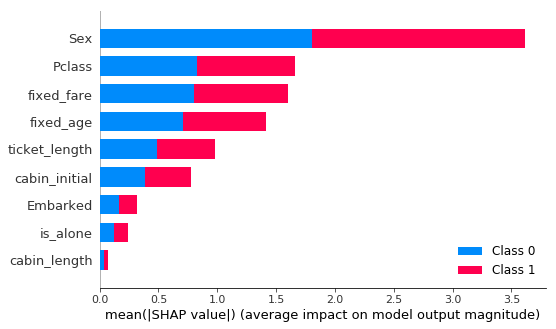

In [68]:
shap_tool.show_summary_plot()

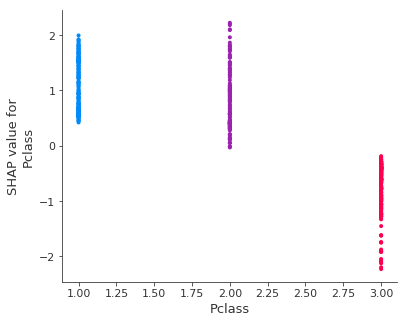

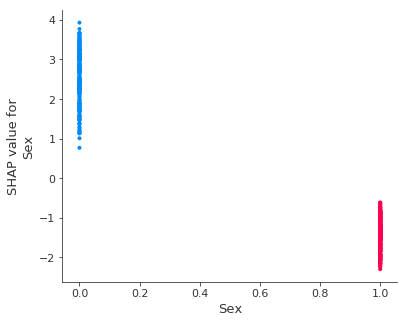

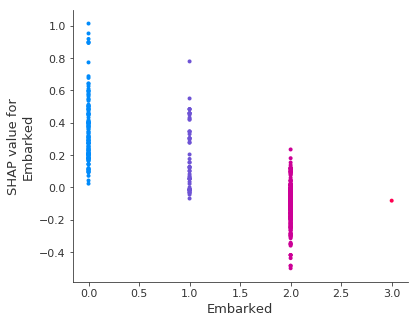

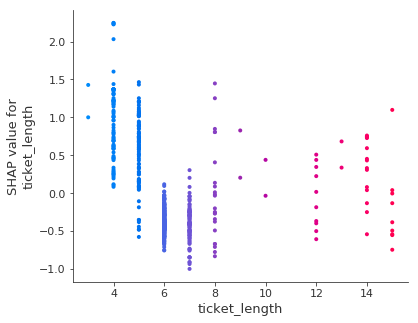

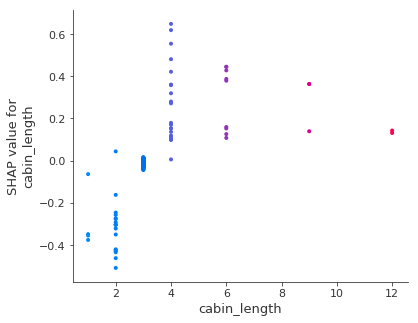

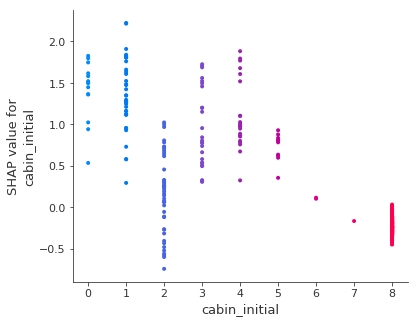

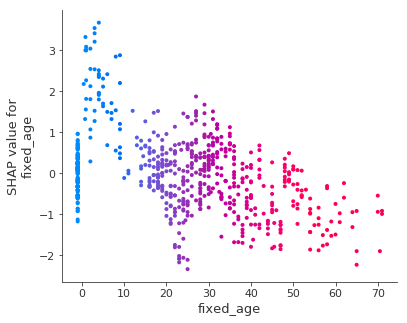

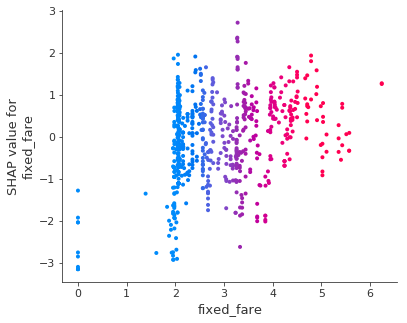

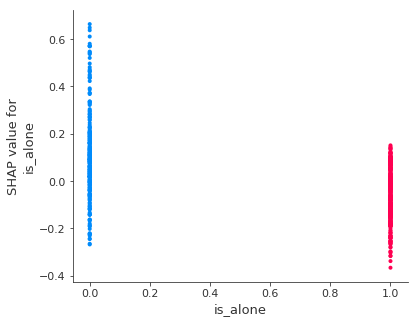

In [69]:
shap_tool.show_all_dependence_plot(type='classification')

# Hyper Parameter Tuning